In [1]:
import pandas as pd
import pyrepseq as prs
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import warnings
import seaborn as sns
import time

from tcrdist.repertoire import TCRrep
from tcrdist.rep_funcs import compute_pw_sparse_out_of_memory
from pyrepseq.metric.tcr_metric import BetaTcrdist
btcrdist = BetaTcrdist()

plt.style.use('bmh')

In [2]:
df = pd.read_csv('/home/andreas/drop/data/emerson/HIP00110.tsv.gz', sep='\t')
df = df[df['amino_acid'].apply(prs.isvalidcdr3)]
df = prs.standardize_dataframe(df, col_mapper={'amino_acid' : 'CDR3B',
                                          'v_family' : 'TRBV',
                                         },
                              suppress_warnings=True)
df.dropna(subset='TRBV', inplace=True)
df.drop_duplicates('CDR3B', inplace=True)
df['CDR3Blen'] = df['CDR3B'].apply(len)
df = df[df['CDR3Blen']>5]
df['TRBV'] = df['TRBV'] + '*01'
df.reset_index(drop=True, inplace=True)

In [3]:
max_tcrdists = np.arange(0, 42, 3)

In [4]:
nsamples = 3
dfs = [df.sample(40000) for i in range(nsamples)]

In [5]:
# warm-up numba for benchmarking
d = dfs[0]
prs.nearest_neighbor_tcrdist(d, max_edits=2,
                             max_tcrdist=0);

In [6]:
neighbors_symdel = {dist:[] for dist in max_tcrdists}
times_symdel = []
for d in dfs:
    told = time.time()
    prs_nn = prs.nearest_neighbor_tcrdist(d, max_edits=2,
                                      max_tcrdist=max_tcrdists[-1])
    for dist in max_tcrdists:
        neighbors_symdel[dist].append((prs_nn[:, 2]<=dist).sum())
    times_symdel.append(time.time()-told)
neighbors_symdel = {key: np.array(value) for key, value in neighbors_symdel.items()}
times_symdel = np.array(times_symdel)

In [7]:
neighbors_symdel

{0: array([154, 138, 142]),
 3: array([180, 168, 168]),
 6: array([356, 330, 310]),
 9: array([832, 824, 752]),
 12: array([7168, 7254, 6960]),
 15: array([7910, 8012, 7660]),
 18: array([11274, 11578, 11126]),
 21: array([20636, 21252, 20798]),
 24: array([87316, 87102, 87330]),
 27: array([87370, 87172, 87398]),
 30: array([87798, 87624, 87878]),
 33: array([89278, 89076, 89330]),
 36: array([100152,  99890,  99908]),
 39: array([100184,  99930,  99946])}

In [8]:
times_symdel

array([4.19877219, 4.46426749, 4.41330576])

In [15]:
neighbors_symdel3 = {dist:[] for dist in max_tcrdists}
times_symdel3 = []
for d in dfs:
    told = time.time()
    prs_nn = prs.nearest_neighbor_tcrdist(d, max_edits=3,
                                      max_tcrdist=max_tcrdists[-1])
    for dist in max_tcrdists:
        neighbors_symdel3[dist].append((prs_nn[:, 2]<=dist).sum())
    times_symdel3.append(time.time()-told)
neighbors_symdel3 = {key: np.array(value) for key, value in neighbors_symdel3.items()}
times_symdel3 = np.array(times_symdel3)

In [16]:
times_symdel3

array([18.31359458, 17.68297553, 18.39152098])

In [17]:
#neighbors_exhaustive = {dist:[] for dist in max_tcrdists}
#times_exhaustive = []
#for d in dfs:
#    told = time.time()
#    nn = btcrdist.calc_pdist_vector(d)
#    for dist in max_tcrdists:
#        neighbors_exhaustive[dist].append((nn<=dist).sum()*2)
#    times_exhaustive.append(time.time()-told)
#neighbors_exhaustive = {key: np.array(value) for key, value in neighbors_exhaustive.items()}
#times_exhaustive = np.array(times_exhaustive)

In [18]:
#neighbors_exhaustive

In [19]:
def convert_df_to_tcrdist_form(df: pd.DataFrame):
    mapper = {
            "TRBV": "v_b_gene",
            "CDR3B": "cdr3_b_aa",
            "rearrangement" : 'cdr3_b_nucseq'}
    df = df.rename(columns=mapper)
    
    df = df[list(mapper.values())]

    if not "count" in df:
        df["count"] = 1

    return df

In [20]:
neighbors_exhaustive = {dist:[] for dist in max_tcrdists}
times_exhaustive = []
for d in dfs:
    d_tcrdist = convert_df_to_tcrdist_form(d)
    d_tcrdist.reset_index(drop=True, inplace=True)
    told = time.time()
    tr = TCRrep(cell_df=d_tcrdist, organism='human', chains=['beta'], compute_distances=False)
#    tr.compute_sparse_rect_distances(radius=max_tcrdists[-1], chunk_size=1000)
#    nn = tr.rw_beta
    nn = compute_pw_sparse_out_of_memory(tr, max_distance=max_tcrdists[-1],
                                         pm_pbar=False, row_size=1000, pm_processes=1)[0]
    for dist in max_tcrdists:
        neighbors_exhaustive[dist].append((nn.data<dist+1).sum()-len(d))
    times_exhaustive.append(time.time()-told)
neighbors_exhaustive = {key: np.array(value) for key, value in neighbors_exhaustive.items()}
times_exhaustive = np.array(times_exhaustive)

CREATED /47629a26ee74/ FOR HOLDING DISTANCE OUT OF MEMORY
RETURNING scipy.sparse csr_matrix w/dims (40000, 40000)
CLEANING UP 47629a26ee74
CREATED /5b5cbb345520/ FOR HOLDING DISTANCE OUT OF MEMORY
RETURNING scipy.sparse csr_matrix w/dims (40000, 40000)
CLEANING UP 5b5cbb345520
CREATED /8c82ecb81813/ FOR HOLDING DISTANCE OUT OF MEMORY
RETURNING scipy.sparse csr_matrix w/dims (40000, 40000)
CLEANING UP 8c82ecb81813


In [21]:
neighbors_exhaustive

{0: array([154, 138, 142]),
 3: array([180, 168, 168]),
 6: array([356, 330, 310]),
 9: array([832, 824, 752]),
 12: array([7168, 7256, 6960]),
 15: array([7914, 8018, 7662]),
 18: array([11328, 11634, 11178]),
 21: array([20954, 21562, 21106]),
 24: array([89014, 88894, 89006]),
 27: array([97656, 98140, 97856]),
 30: array([135318, 136346, 136172]),
 33: array([227092, 228782, 228990]),
 36: array([631570, 636254, 638232]),
 39: array([686822, 692758, 694062])}

In [22]:
fraction = np.array([neighbors_symdel[dist].sum()/neighbors_exhaustive[dist].sum() for dist in max_tcrdists])

In [23]:
fraction3 = np.array([neighbors_symdel3[dist].sum()/neighbors_exhaustive[dist].sum() for dist in max_tcrdists])

In [24]:
list(zip(max_tcrdists, fraction))

[(0, 1.0),
 (3, 1.0),
 (6, 1.0),
 (9, 1.0),
 (12, 0.9999064721286943),
 (15, 0.999491396117657),
 (18, 0.9952548330404218),
 (21, 0.9852881078872088),
 (24, 0.9806454513438786),
 (27, 0.8920082274256603),
 (30, 0.6456026442001197),
 (33, 0.39085716288197364),
 (36, 0.15736683497231982),
 (39, 0.14470193022710767)]

In [43]:
list(zip(max_tcrdists, fraction3))

[(0, 1.0),
 (3, 1.0),
 (6, 1.0),
 (9, 1.0),
 (12, 1.0),
 (15, 1.0),
 (18, 1.0),
 (21, 1.0),
 (24, 0.9999400555984325),
 (27, 0.9994415158078269),
 (30, 0.9966408065987309),
 (33, 0.9875157695542472),
 (36, 0.9768758105742958),
 (39, 0.90042543505581)]

In [25]:
times_exhaustive.mean()/times_symdel.mean(), times_exhaustive.mean()/times_symdel3.mean()

(98.35140465966556, 23.64629676265215)

In [34]:
axes[0].plot?

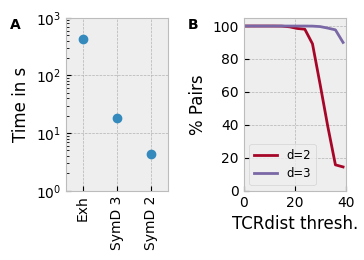

In [42]:
fig, axes = plt.subplots(figsize=(3.42, 2.4), ncols=2)
axes[0].plot(['Exh', 'SymD 3', 'SymD 2'],
             [np.mean(times_exhaustive), np.mean(times_symdel3), np.mean(times_symdel)],
             'o', markeredgecolor=None)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylabel('Time in s')
axes[0].set_yscale('log')
axes[0].set_ylim(1, 1000)
axes[0].set_xlim(-0.5, 2.5)
axes[1].plot(max_tcrdists, fraction*100, label='d=2', color='C1')
axes[1].plot(max_tcrdists, fraction3*100, label='d=3', color='C2')
axes[1].legend(fontsize='small')
axes[1].set_xlabel('TCRdist thresh.')
axes[1].set_ylabel('% Pairs')
axes[1].set_ylim(0, 105)
axes[1].set_xlim(0, 40)
fig.tight_layout(w_pad=1.5, pad=0.0)
prs.plotting.label_axes(fig,xy=(-0.55, 1.0))
fig.savefig('tcrdist_benchmark.pdf')
fig.savefig('tcrdist_benchmark.svg')